In [7]:
library("ggplot2")
library("dplyr")
library("tidyr")
library(MMWRweek)
library("lubridate")


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [43]:
us_death = read.csv(file="../data//Provisional_COVID-19_Death_Counts_by_Week_Ending_Date_and_State.csv")
us_death$Week.Ending.Date = mdy(us_death$Week.Ending.Date)
us_death = us_death[us_death$State == "United States", ]
us_death = us_death[year(us_death$Week.Ending.Date) < 2022, ]
us_death = us_death[!is.na(us_death$Total.Deaths) & !is.na(us_death$Week.Ending.Date), ]
head(us_death)

,Data.as.of,Start.Date,End.Date,Group,Year,Month,MMWR.Week,Week.Ending.Date,State,COVID.19.Deaths,Total.Deaths,Percent.of.Expected.Deaths,Pneumonia.Deaths,Pneumonia.and.COVID.19.Deaths,Influenza.Deaths,Pneumonia..Influenza..or.COVID.19.Deaths,Footnote
,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<date>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>
1,01/27/2022,12/29/2019,01/04/2020,By Week,2019/2020,NA,1,2020-01-04,United States,0,60173,98,4111,0,434,4545,
2,01/27/2022,01/05/2020,01/11/2020,By Week,2020,NA,2,2020-01-11,United States,1,60732,97,4153,1,475,4628,
3,01/27/2022,01/12/2020,01/18/2020,By Week,2020,NA,3,2020-01-18,United States,2,59359,98,4066,2,468,4534,
4,01/27/2022,01/19/2020,01/25/2020,By Week,2020,NA,4,2020-01-25,United States,2,59158,99,3915,0,500,4417,
5,01/27/2022,01/26/2020,02/01/2020,By Week,2020,NA,5,2020-02-01,United States,0,58826,99,3818,0,481,4299,
6,01/27/2022,02/02/2020,02/08/2020,By Week,2020,NA,6,2020-02-08,United States,3,59478,100,3823,1,521,4346,


In [44]:
unique(us_death$State)

[1] "United States"

In [47]:
d_min = min(us_death$Total.Deaths)
d_max = max(us_death$Total.Deaths)
us_death$total.death.norm = (us_death$Total.Deaths - d_min) / (d_max - d_min)

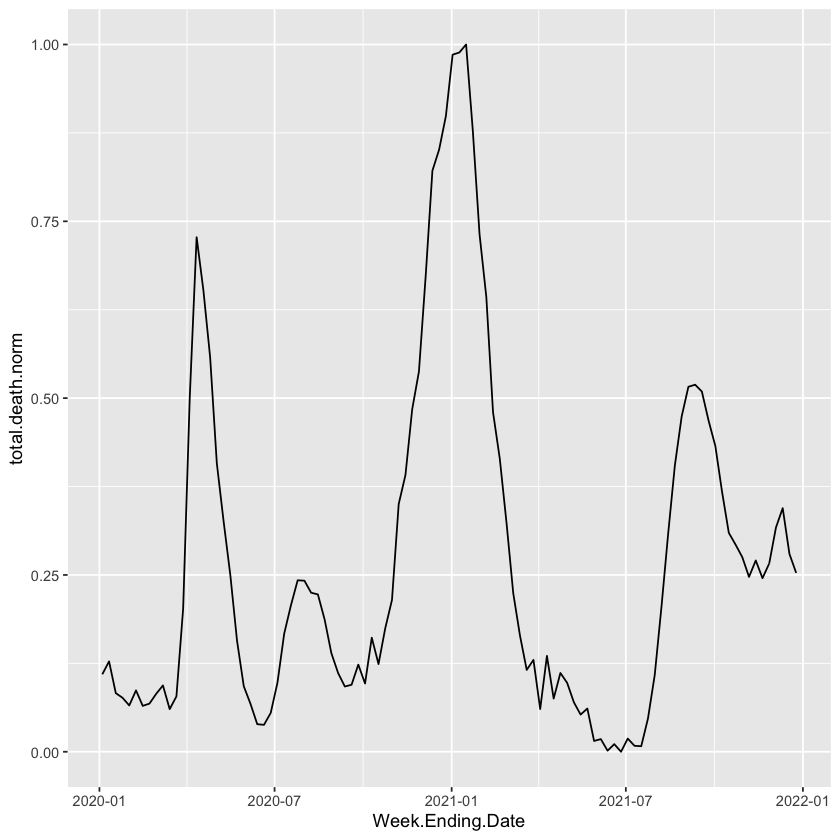

In [48]:
a = ggplot(us_death, aes(x=Week.Ending.Date, y=total.death.norm))
a + geom_line()

In [35]:
max(us_death$Total.Deaths)

[1] 6927615

In [36]:
summary(us_death)

  Data.as.of         Start.Date          End.Date            Group          
 Length:137         Length:137         Length:137         Length:137        
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
     Year               Month         MMWR.Week     Week.Ending.Date    
 Length:137         Min.   : 1.00   Min.   : 1.00   Min.   :2020-01-04  
 Class :character   1st Qu.: 3.00   1st Qu.:12.75   1st Qu.:2020-07-09  
 Mode  :character   Median : 6.00   Median :26.00   Median :2021-01-12  
                    Mean   : 6.28   Mean   :26.06   Mean   :2021-01-12  
                   